# Lab 5: 

Lab session by:
* Daniel Hess
* Pandelis Laurens Symeonidis

In [2]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet_ic')

from nltk.corpus import wordnet_ic, wordnet as wn
from itertools import combinations, product
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


### Penn tag to Wordnet mapping

In [3]:
def convert_category(word: str, penn_tag: str):
    d = {'NN': 'n', 'NNS': 'n',
          'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
            'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
            'RB': 'r', 'RBR': 'r', 'RBS': 'r'} 
    
    if penn_tag in d: 
        return word, d[penn_tag]
    else:
        return word, None 

### Step 1 Convert penn -> wordnet (POS)

In [4]:
pairs_penn = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'),
('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]

converted = [convert_category(w, t) for w, t in pairs_penn]
pairs_wn = [pair for pair in converted if pair[1]] # If pos = None, it is not indexed by wordnet
print(pairs_wn)

synsets = [wn.synsets(lemma=w, pos=t)[0] for w, t in pairs_wn] # Compute most frequent synset AKA synsets[0] as they are ordered by frequency
print(synsets)
print(synsets[0].lowest_common_hypernyms(synsets[2]))


[('man', 'n'), ('swim', 'v'), ('girl', 'n'), ('boy', 'n'), ('woman', 'n'), ('walk', 'v')]
[Synset('man.n.01'), Synset('swim.v.01'), Synset('girl.n.01'), Synset('male_child.n.01'), Synset('woman.n.01'), Synset('walk.v.01')]
[Synset('adult.n.01')]
[Synset('man.n.01'), Synset('swim.v.01'), Synset('girl.n.01'), Synset('male_child.n.01'), Synset('woman.n.01'), Synset('walk.v.01')]
[Synset('adult.n.01')]


### Step 2 compute most frequenst synset for each word and confirm it is the most frequent

In [5]:
synsets = [wn.synsets(lemma=w, pos=t)[0] for w, t in pairs_wn] # Compute most frequent synset AKA synsets[0] as they are ordered by frequency
print(synsets)

# Confirm that synsets[0] is the most frequent by checking lemma counts
print("\nVerifying that synsets[0] is the most frequent:")
for (word, pos), synset in zip(pairs_wn, synsets):
    all_synsets = wn.synsets(lemma=word, pos=pos)
    print(f"\nWord: {word} (pos: {pos})")
    print(f"Selected synset: {synset.name()}")
    
    # Get all lemmas for this synset and find the one matching our word
    synset_lemmas = [lemma for lemma in synset.lemmas() if lemma.name() == word]
    if synset_lemmas:
        selected_count = synset_lemmas[0].count()
        print(f"Count for selected synset: {selected_count}")
        
        # Check counts for all synsets of this word
        print("All synsets and their counts:")
        for i, s in enumerate(all_synsets):
            s_lemmas = [lemma for lemma in s.lemmas() if lemma.name() == word]
            if s_lemmas:
                count = s_lemmas[0].count()
                marker = " ← SELECTED" if i == 0 else ""
                print(f"  {i}: {s.name()} -> count: {count}{marker}")
        
        # Verify that the first synset has the highest count
        max_count = max([lemma.count() for s in all_synsets for lemma in s.lemmas() if lemma.name() == word])
        is_most_frequent = selected_count == max_count
        print(f"Most frequent: {is_most_frequent} (max count: {max_count})")
    else:
        print(f"No lemma found for word '{word}' in synset {synset.name()}")

[Synset('man.n.01'), Synset('swim.v.01'), Synset('girl.n.01'), Synset('male_child.n.01'), Synset('woman.n.01'), Synset('walk.v.01')]

Verifying that synsets[0] is the most frequent:

Word: man (pos: n)
Selected synset: man.n.01
Count for selected synset: 749
All synsets and their counts:
  0: man.n.01 -> count: 749 ← SELECTED
  1: serviceman.n.01 -> count: 346
  2: man.n.03 -> count: 87
  3: homo.n.02 -> count: 29
  4: man.n.05 -> count: 4
  5: man.n.06 -> count: 3
  6: valet.n.01 -> count: 0
  7: man.n.08 -> count: 0
  9: man.n.10 -> count: 0
  10: world.n.08 -> count: 0
Most frequent: True (max count: 749)

Word: swim (pos: v)
Selected synset: swim.v.01
Count for selected synset: 12
All synsets and their counts:
  0: swim.v.01 -> count: 12 ← SELECTED
  1: float.v.02 -> count: 1
  2: swim.v.03 -> count: 0
  3: swim.v.04 -> count: 0
  4: swim.v.05 -> count: 0
Most frequent: True (max count: 12)

Word: girl (pos: n)
Selected synset: girl.n.01
Count for selected synset: 80
All synsets an

### Step 3 Compute the least common hypernim whenever possible
(It is not possible to do it when pos1!=pos2, cant get common hypernim of a verb vs noun)

In [6]:
content = [(w, t, wn.synsets(lemma=w, pos=t)[0]) for w, t, in pairs_wn]

def depth(syn):
    # depth = longest hypernym path length minus 1 (root=0)
    return max(len(p) for p in syn.hypernym_paths()) - 1

results = []
for (w1, pos1, s1), (w2, pos2, s2) in combinations(content, 2):
    if pos1 != pos2:
        continue  # nouns with nouns, verbs with verbs
    
    lchs = s1.lowest_common_hypernyms(s2)
    
    if lchs:  # Check if there are any common hypernyms
        lch = max(lchs, key=depth)  # Get the deepest (most specific) common hypernym
        print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}] -> LCH: {lch.name()} (depth={depth(lch)})")
    else:
        print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}] -> No common hypernyms found")

man[man.n.01] ~ girl[girl.n.01] -> LCH: adult.n.01 (depth=7)
man[man.n.01] ~ boy[male_child.n.01] -> LCH: male.n.02 (depth=7)
man[man.n.01] ~ woman[woman.n.01] -> LCH: adult.n.01 (depth=7)
swim[swim.v.01] ~ walk[walk.v.01] -> LCH: travel.v.01 (depth=0)
girl[girl.n.01] ~ boy[male_child.n.01] -> LCH: person.n.01 (depth=6)
girl[girl.n.01] ~ woman[woman.n.01] -> LCH: woman.n.01 (depth=8)
boy[male_child.n.01] ~ woman[woman.n.01] -> LCH: person.n.01 (depth=6)


## Another Way of checking best lch, not deepest.

In [7]:
def best_lch(word1, pos1, word2, pos2):
    syns1 = wn.synsets(word1, pos1)
    syns2 = wn.synsets(word2, pos2)
    best = None
    best_score = -1
    for s1, s2 in product(syns1, syns2):
        lchs = s1.lowest_common_hypernyms(s2)
        if not lchs: 
            continue
        lch = max(lchs, key=depth)
        if depth(lch) > best_score:
            best = (s1, s2, lch)
            best_score = depth(lch)
    return best 

for (w1,p1),(w2,p2) in combinations([(w,p) for w,p,_ in content], 2):
    if p1 != p2: 
        continue
    res = best_lch(w1,p1,w2,p2)
    if not res: 
        continue
    s1, s2, lch = res
    print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}] -> LCH: {lch.name()} (depth={depth(lch)})")

man[man.n.01] ~ girl[girl.n.01] -> LCH: adult.n.01 (depth=7)
man[man.n.01] ~ boy[boy.n.02] -> LCH: man.n.01 (depth=8)
man[man.n.01] ~ woman[woman.n.01] -> LCH: adult.n.01 (depth=7)
swim[swim.v.01] ~ walk[walk.v.01] -> LCH: travel.v.01 (depth=0)
girl[daughter.n.01] ~ boy[son.n.01] -> LCH: child.n.02 (depth=9)
girl[girl.n.01] ~ woman[woman.n.01] -> LCH: woman.n.01 (depth=8)
boy[boy.n.02] ~ woman[woman.n.01] -> LCH: adult.n.01 (depth=7)


### Step 4 compute similarity between pairs (when possible aka pos1=pos2) using 4 different methods

In [8]:
brown_ic = wordnet_ic.ic('ic-brown.dat')

def fmt(x, nd=3):
    return "—" if x is None else f"{x:.{nd}f}"

# Store similarity scores for each method
similarity_scores_path = []
similarity_scores_lch = []
similarity_scores_wup = []
similarity_scores_lin = []
pair_labels = []

for (w1, pos1, s1), (w2, pos2, s2) in combinations(content, 2):
    path = s1.path_similarity(s2)
    try:
        lch = s1.lch_similarity(s2)
    except Exception:
        lch = None
    wup = s1.wup_similarity(s2)
    try:
        lin = s1.lin_similarity(s2, brown_ic) if pos1 in ('n', 'v') else None
    except Exception:
        lin = None

    # Store results
    similarity_scores_path.append(path)
    similarity_scores_lch.append(lch)
    similarity_scores_wup.append(wup)
    similarity_scores_lin.append(lin)
    pair_labels.append(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}]")

    print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}]")
    print(f"  path={fmt(path)}  lch={fmt(lch)}  wup={fmt(wup)}  lin={fmt(lin)}\n")

man[man.n.01] ~ swim[swim.v.01]
  path=0.100  lch=—  wup=0.182  lin=—

man[man.n.01] ~ girl[girl.n.01]
  path=0.250  lch=2.251  wup=0.632  lin=0.714

man[man.n.01] ~ boy[male_child.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.729

man[man.n.01] ~ woman[woman.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.787

man[man.n.01] ~ walk[walk.v.01]
  path=0.100  lch=—  wup=0.182  lin=—

swim[swim.v.01] ~ girl[girl.n.01]
  path=0.091  lch=—  wup=0.167  lin=—

swim[swim.v.01] ~ boy[male_child.n.01]
  path=0.100  lch=—  wup=0.182  lin=—

swim[swim.v.01] ~ woman[woman.n.01]
  path=0.100  lch=—  wup=0.182  lin=—

man[man.n.01] ~ girl[girl.n.01]
  path=0.250  lch=2.251  wup=0.632  lin=0.714

man[man.n.01] ~ boy[male_child.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.729

man[man.n.01] ~ woman[woman.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.787

man[man.n.01] ~ walk[walk.v.01]
  path=0.100  lch=—  wup=0.182  lin=—

swim[swim.v.01] ~ girl[girl.n.01]
  path=0.091  lch=—  wup=0.167  lin=—



### TODO

- Confirm that synsets[0] is most frequent, by using .count() on the lemma (not very sure what that means)
- Normalize similarities of each method so that they are comparable
- Why does the least common hypernym sometimes not make sense (depending on which sense/synset you use) -> not the same comparing man v.s boy and man v.s male_child
- Analysis

## Analysis

[[0.1               nan 0.18181818        nan]
 [0.25       0.61029151 0.63157895 0.71351112]
 [0.33333333 0.68827781 0.66666667 0.72947179]
 [0.33333333 0.68827781 0.66666667 0.78708414]
 [0.1               nan 0.18181818        nan]
 [0.09090909        nan 0.16666667        nan]
 [0.1               nan 0.18181818        nan]
 [0.1               nan 0.18181818        nan]
 [0.33333333 0.58540385 0.33333333 0.4910052 ]
 [0.16666667 0.50037599 0.63157895 0.29272807]
 [0.5        0.79819333 0.63157895 0.90677986]
 [0.09090909        nan 0.16666667        nan]
 [0.2        0.54980063 0.66666667 0.31842336]
 [0.1               nan 0.18181818        nan]
 [0.1               nan 0.18181818        nan]]
['man[man.n.01] ~ swim[swim.v.01]' 'man[man.n.01] ~ girl[girl.n.01]'
 'man[man.n.01] ~ boy[male_child.n.01]'
 'man[man.n.01] ~ woman[woman.n.01]' 'man[man.n.01] ~ walk[walk.v.01]'
 'swim[swim.v.01] ~ girl[girl.n.01]'
 'swim[swim.v.01] ~ boy[male_child.n.01]'
 'swim[swim.v.01] ~ woman[woman.n.0

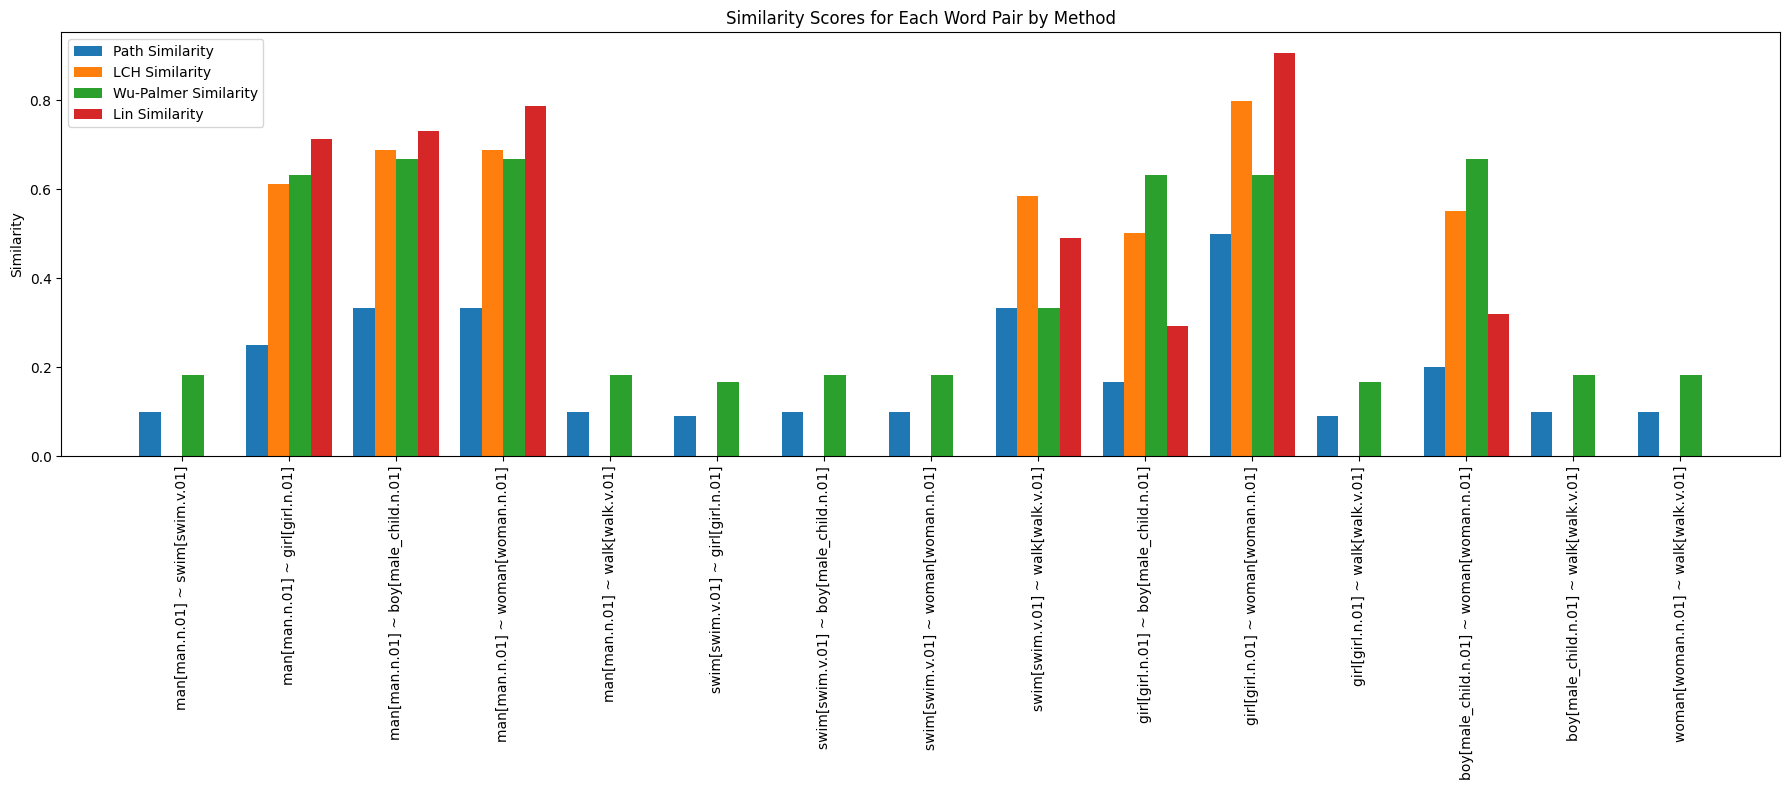

In [9]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Path Similarity", "LCH Similarity", "Wu-Palmer Similarity", "Lin Similarity"]
methods = [similarity_scores_path, similarity_scores_lch, similarity_scores_wup, similarity_scores_lin]
pairs = np.array(pair_labels)

# Only normalize LCH similarity using theoretical max value; others remain unchanged
method_arrays = []
# Set max depth for WordNet taxonomy (e.g., nouns D=20, so max_lch = log(40))
D = 20
max_lch = np.log(2 * D)  # ≈ 3.688879 for D=20

for i, scores in enumerate(methods):
    arr = np.array([s if s is not None else np.nan for s in scores])
    if i == 1:  # LCH Similarity
        arr_norm = arr / max_lch
        method_arrays.append(arr_norm)
    else:
        method_arrays.append(arr)

similarities = np.vstack(method_arrays).T  # shape: (num_pairs, num_methods)
print(similarities)
print(pairs)

plt.figure(figsize=(18, 8))
bar_width = 0.2
x = np.arange(len(pairs))
for i, label in enumerate(labels):
    plt.bar(x + i * bar_width, similarities[:, i], width=bar_width, label=label)
plt.xticks(x + 1.5 * bar_width, pairs, rotation=90)
plt.ylabel('Similarity')
plt.title('Similarity Scores for Each Word Pair by Method')
plt.legend()
plt.tight_layout()
plt.show()